# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe().T

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.info

<bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values

azdias.isnull().sum().head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [11]:
azdias.isnull().sum().sum()

4896838

In [12]:
feat_info.missing_or_unknown

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [13]:
# Remove brackets, split data with commas, change data to datatype int, replace missing data with NaN
for x in range(azdias.shape[1]):
    missing_or_unknown = feat_info.loc[x,'missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[]').split(',')
    
    for i in range(len(missing_or_unknown)):
        try:
            missing_or_unknown[i] = int(missing_or_unknown[i])
        except:
            continue
        
    azdias.loc[:,(feat_info.loc[x, 'attribute'])].replace(missing_or_unknown, np.nan, inplace=True)

In [14]:
azdias.isnull().sum().head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [15]:
azdias.isnull().sum().sum()

8373929

In [16]:
# Verifiy changes have been made

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_data = azdias.isnull().sum()[azdias.isnull().sum() > 0]
missing_data

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

In [18]:
# Sort data from least to greatest

missing_data.sort_values(inplace=True, ascending = True)

In [19]:
# Investigate patterns in the amount of missing data in each column.
#View percentage of missing data

p_missing_data = missing_data/len(azdias) * 100
p_missing_data

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

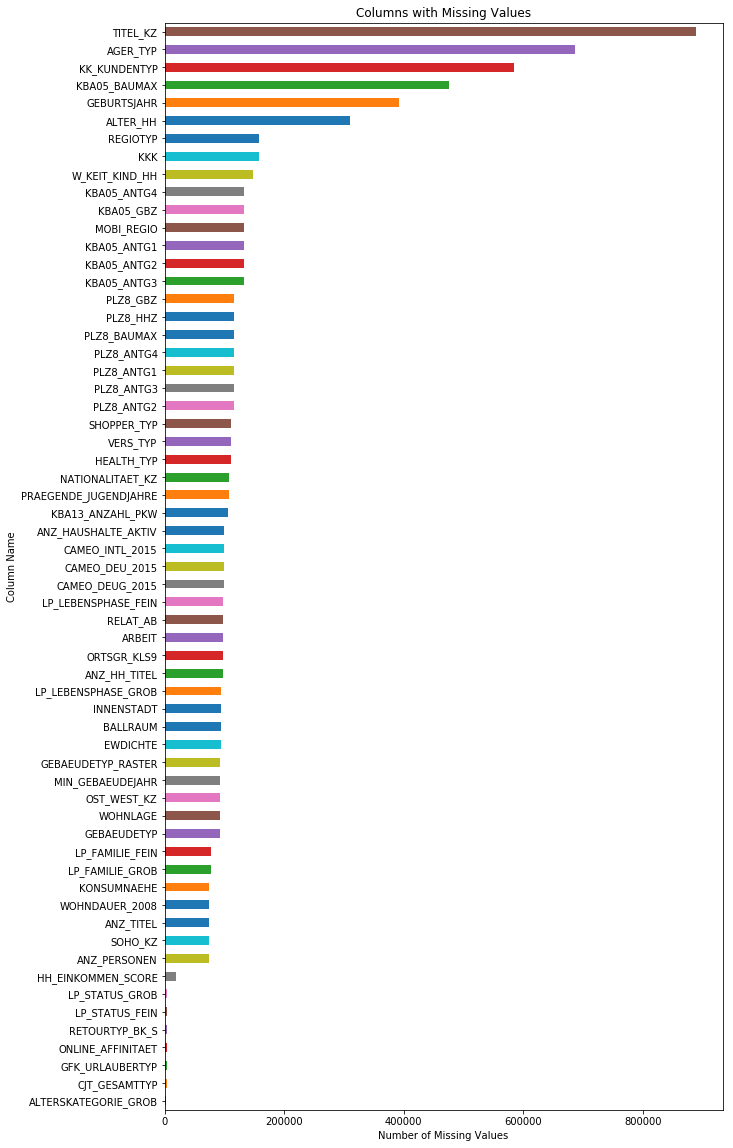

In [20]:
# Bar graph of missing value counts

missing_data.plot.barh(figsize = (10, 20));
plt.title('Columns with Missing Values');
plt.ylabel('Column Name');
plt.xlabel('Number of Missing Values');
plt.show();

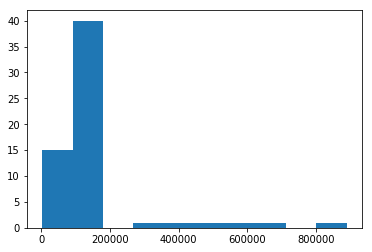

In [21]:
plt.hist(missing_data);

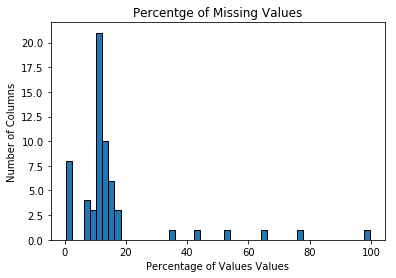

In [22]:
plt.hist(p_missing_data, edgecolor = 'black', bins = 50);
plt.title('Percentge of Missing Values');
plt.ylabel('Number of Columns');
plt.xlabel('Percentage of Values Values');
plt.show();

In [23]:
# View columns with missing values >30% 
# These are the outliers

outliers = missing_data[p_missing_data > 30].index
outliers

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(outliers, axis = 1, inplace = True)

In [25]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The data has 61 columns with missing data. Several of the columns in the data appear to be related, with the same percentage of data missing. It seems that missing data in one column may correlate with missing data in 1 or more additional columns.
Six columns were identified as outliers (ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, TITEL_KZ) and removed. All of these columns had over 30% of their values missing. The percentage of missing values for these columns ranged from ~34% - ~99%.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis = 1)[azdias.isnull().sum(axis = 1) > 0]
missing_rows.sort_values(ascending = False)

732775    49
643174    49
472919    48
604334    47
604314    47
768879    47
604319    47
604322    47
604323    47
275622    47
62901     47
275620    47
604332    47
275617    47
604305    47
275611    47
275610    47
62912     47
604335    47
604338    47
604346    47
604350    47
146293    47
604356    47
62887     47
768892    47
146291    47
348454    47
604091    47
604092    47
          ..
38561      1
768647     1
607245     1
709042     1
507663     1
607271     1
561427     1
235434     1
235435     1
235445     1
607405     1
62924      1
144785     1
91916      1
820005     1
607433     1
709002     1
38612      1
144760     1
561377     1
607469     1
423798     1
423777     1
507723     1
768704     1
736034     1
736038     1
768679     1
736043     1
237075     1
Length: 268012, dtype: int64

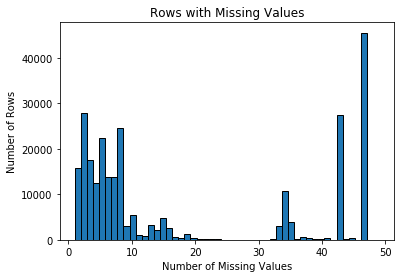

In [27]:
# Histogram to show the distribution of missing data

plt.hist(missing_rows, edgecolor = 'black', bins = 50);
plt.title('Rows with Missing Values');
plt.ylabel('Number of Rows');
plt.xlabel('Number of Missing Values');
plt.show();

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_rows1 = azdias[azdias.isnull().sum(axis = 1) < 30]
missing_rows2 = azdias[azdias.isnull().sum(axis = 1) >= 30]

In [29]:
missing_rows1.index, missing_rows2.index

(Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                  9,     10,
             ...
             891211, 891212, 891213, 891214, 891215, 891216, 891217, 891218,
             891219, 891220],
            dtype='int64', length=798061),
 Int64Index([     0,     11,     14,     17,     24,     30,     35,     46,
                 48,     53,
             ...
             891100, 891130, 891137, 891140, 891159, 891164, 891171, 891175,
             891185, 891187],
            dtype='int64', length=93160))

In [30]:
# Percentage of missing data in each group

p_less_than_30 = len(missing_rows1) / (len(missing_rows1) + len(missing_rows2)) * 100
p_30_or_more = len(missing_rows2) / (len(missing_rows1) + len(missing_rows2)) * 100

p_less_than_30, p_30_or_more

(89.5469249490306, 10.4530750509694)

In [31]:
# Columns with no missing data

complete = azdias.isnull().sum()[azdias.isnull().sum() == 0]
complete

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def comparison(c):
    fig = plt.figure(10, figsize=(20,5))
    
    axis1 = fig.add_subplot(121)
    axis1.title.set_text('Few Missing Values')
    sns.countplot(missing_rows1[c])
    
    axis2 = fig.add_subplot(122)
    axis2.title.set_text('Many Missing Values')
    sns.countplot(missing_rows2[c])
                                                       
    fig.suptitle(c)
    plt.show()

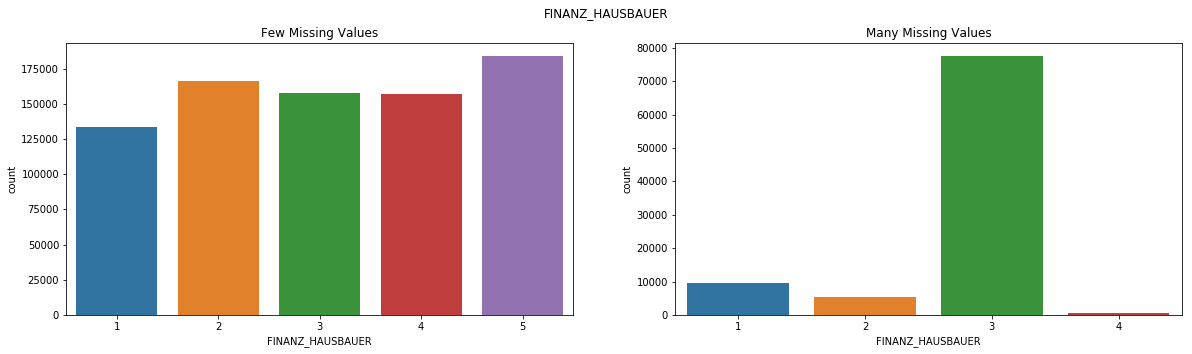

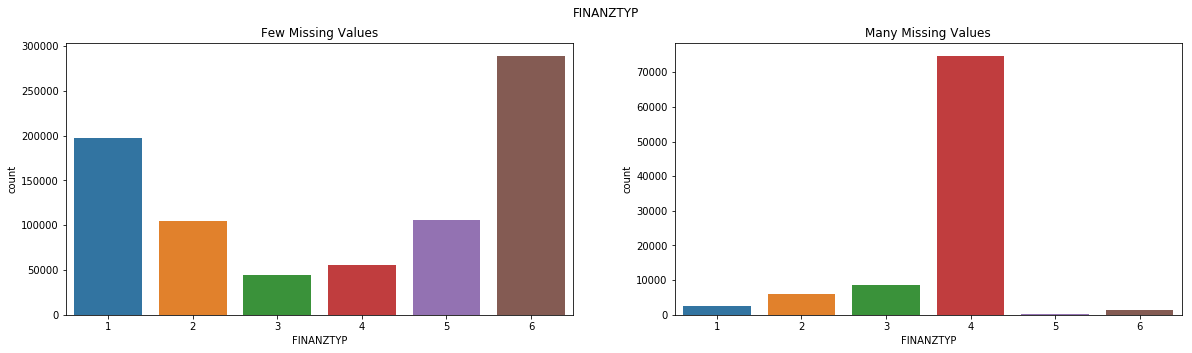

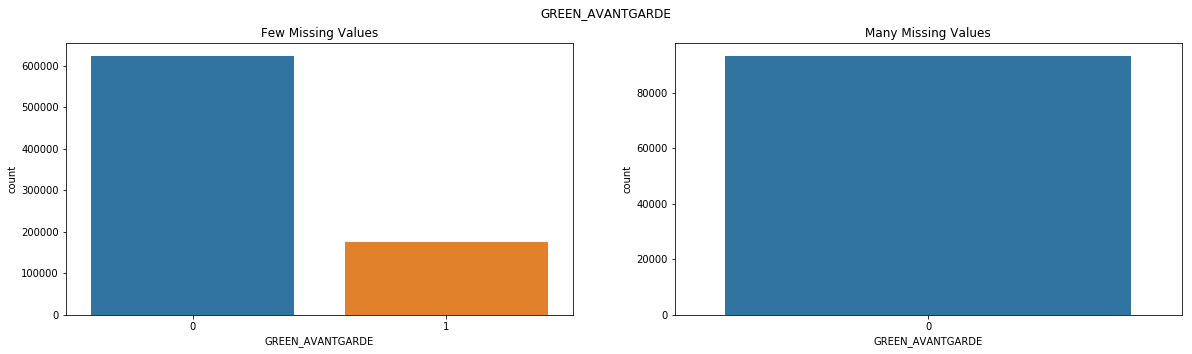

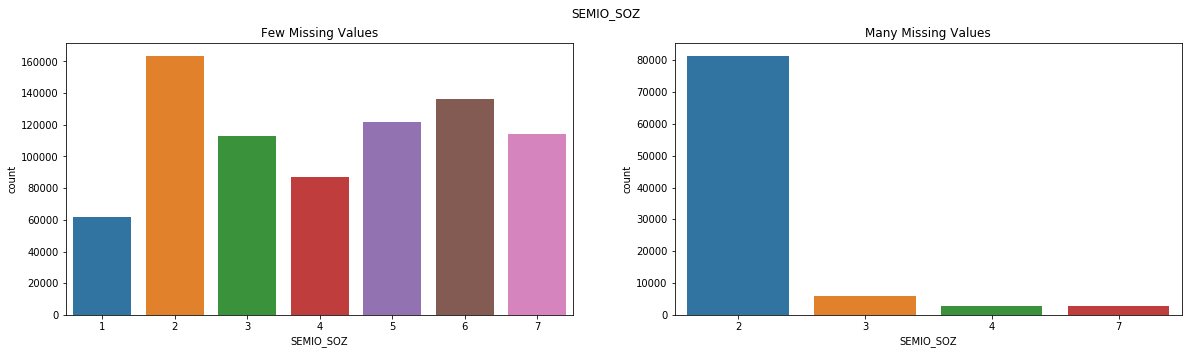

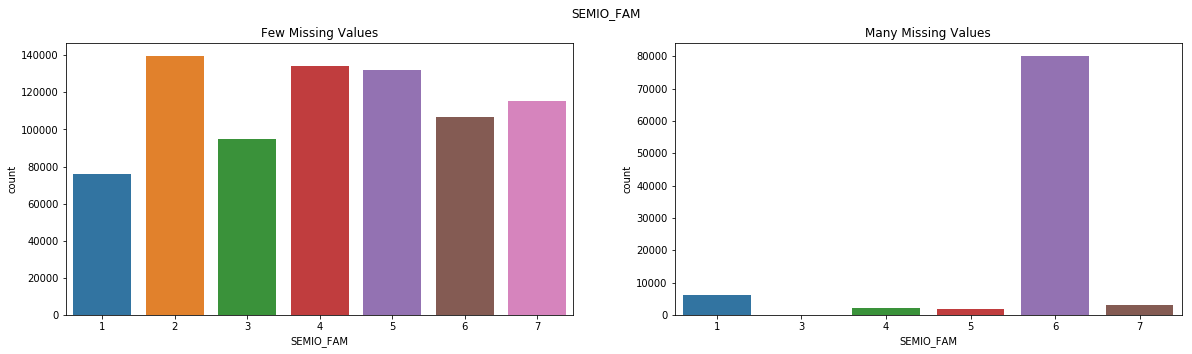

In [33]:
# View figures for the columns
 
for i in range(11):
    if i > 5:
        comparison(complete.index[i])

In [34]:
azdias2 = missing_rows1

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data was split into 2 groups, rows with <30 pieces of missing data and rows with >=30 pieces of missing data. 
There is substantially more missing data in the <30 group. (Note that figures have different scaling). The <30 group makes up ~90% of the missing data, while the >=30 group only accounts for ~10% of the missing data.
The data with many missing values and the data with no missing values look very different. However, due to the small number of data present in the >=30 group when compared to the <30 group, dropping these values is unlikey to present a problem.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# All categorical variables

feat_info[feat_info.type == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info.loc[feat_info.type == 'categorical', 'attribute'].values
categorical = [categorical for categorical in categorical if categorical in azdias2.columns] 

In [38]:
# Binary categoricals have exactly 2 values.
# Multi-level categoricals have 3 or more values.

categorical_b = [c for c in categorical if azdias2[c].nunique() == 2]
categorical_m = [c for c in categorical if azdias2[c].nunique() >= 3]

In [39]:
# List of binary categoricals

categorical_b

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [40]:
# List of multi-level categoricals

categorical_m

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.

for x in categorical:
    if azdias2[x].nunique() == 2:
        categorical_b.append(x)

In [42]:
azdias2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     795258 non-null float64
ANREDE_KZ                798061 non-null int64
CJT_GESAMTTYP            793316 non-null float64
FINANZ_MINIMALIST        798061 non-null int64
FINANZ_SPARER            798061 non-null int64
FINANZ_VORSORGER         798061 non-null int64
FINANZ_ANLEGER           798061 non-null int64
FINANZ_UNAUFFAELLIGER    798061 non-null int64
FINANZ_HAUSBAUER         798061 non-null int64
FINANZTYP                798061 non-null int64
GFK_URLAUBERTYP          793316 non-null float64
GREEN_AVANTGARDE         798061 non-null int64
HEALTH_TYP               761340 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
LP_FAMILIE_FEIN          766593 non-null float64
LP_FAMILIE_GROB          766593 non-null float64
LP_STATUS_FEIN           793316 non-null float64
LP_STATUS_GROB           

In [43]:
# Drop multi-level categoricals

azdias2.drop(categorical_m, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:
# Verify multi-level categoricals columns were dropped

azdias2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     795258 non-null float64
ANREDE_KZ                798061 non-null int64
FINANZ_MINIMALIST        798061 non-null int64
FINANZ_SPARER            798061 non-null int64
FINANZ_VORSORGER         798061 non-null int64
FINANZ_ANLEGER           798061 non-null int64
FINANZ_UNAUFFAELLIGER    798061 non-null int64
FINANZ_HAUSBAUER         798061 non-null int64
GREEN_AVANTGARDE         798061 non-null int64
HEALTH_TYP               761340 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
PRAEGENDE_JUGENDJAHRE    769306 non-null float64
RETOURTYP_BK_S           793316 non-null float64
SEMIO_SOZ                798061 non-null int64
SEMIO_FAM                798061 non-null int64
SEMIO_REL                798061 non-null int64
SEMIO_MAT                798061 non-null int64
SEMIO_VERT               798061

In [45]:
# View values in variable with non-numeric values

azdias2.OST_WEST_KZ.value_counts()

W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64

In [46]:
# Convert non-numeric values to numeric values

azdias2.loc[:, 'OST_WEST_KZ'].replace({'O':0, 'W':1}, inplace=True);

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [47]:
# Verify values are now numeric 

azdias2.OST_WEST_KZ.sample(5)

260455    0
161998    1
763816    1
752458    1
367815    1
Name: OST_WEST_KZ, dtype: int64

In [48]:
#Check the number of remaing columns

azdias2.shape

(798061, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are a total of 18 categorical variable. Five are binary categoricals and the remaining 13 are multi-level categoricals. The 13 multi-level categoricals were identified and dropped. After identifying the 5 categorical variables, the one non-numeric column (OST_WEST_KZ) needed to be re-encoded. The column contained values of O and W, which were re-encode to 0 and 1 respectively. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
feat_info[feat_info.type=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [50]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias2.PRAEGENDE_JUGENDJAHRE.head(5)

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [51]:
# Function to convert the years into numeric values

def years(x):
    if x in (1, 2):
        return 1
    if x in (3, 4):
        return 2
    if x in (5, 6, 7):
        return 3
    if x in (8, 9):
        return 4
    if x in (10, 11, 12, 13):
        return 5
    if x in (14, 15):
        return 6
    else:
        return np.nan

In [52]:
# Function to convert the movement into numerical values

def movement(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    if x in (2,4,6,7,9,11,13,15):
        return 1
    else:
        return np.nan

In [53]:
# Create new columns for decade and movement

azdias2['PRAEGENDE_JUGENDJAHRE_YEARS'] = azdias2['PRAEGENDE_JUGENDJAHRE'].apply(years)
azdias2['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias2['PRAEGENDE_JUGENDJAHRE'].apply(movement)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [54]:
# Verify new columns have been created

azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_YEARS,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0


In [55]:
# Drop the original column

azdias2.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [56]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias2.CAMEO_INTL_2015.value_counts()

51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [57]:
# Function to convert wealth into numeric values

def wealth(x):
    if x//10 == 1:
        return 1
    if x//10 == 2:
        return 2
    if x//10 == 3:
        return 3
    if x//10 == 4:
        return 4
    if x//10 == 5:
        return 5
    else:
        return np.nan

In [58]:
# Function to convert life stage into numeric values

def life_stage(x):
    if x%10 == 1:
        return 1
    if x%10 == 2:
        return 2
    if x%10 == 3:
        return 3
    if x%10 == 4:
        return 4
    if x%10 == 5:
        return 5
    else:
        return np.nan

In [59]:
# Convert CAMEO_INTL_2015 from string to numeric

azdias2['CAMEO_INTL_2015'] = pd.to_numeric(azdias2['CAMEO_INTL_2015'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
#Confirm datatype change

azdias2['CAMEO_INTL_2015'].dtypes

dtype('float64')

In [61]:
# Create new columns for decade and movement

azdias2['CAMEO_INTL_2015_WEALTH'] = azdias2['CAMEO_INTL_2015'].apply(wealth)
azdias2['CAMEO_INTL_2015_LIFE_STAGE'] = azdias2['CAMEO_INTL_2015'].apply(life_stage)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [62]:
# Drop the original column

azdias2.drop('CAMEO_INTL_2015', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [63]:
# Verify new columns have been created

azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_YEARS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0


In [64]:
# Drop additional columms that will not be used

azdias2 = azdias2.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'],axis=1)

In [65]:
# Verify all columns are now numeric types
azdias2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB              795258 non-null float64
ANREDE_KZ                         798061 non-null int64
FINANZ_MINIMALIST                 798061 non-null int64
FINANZ_SPARER                     798061 non-null int64
FINANZ_VORSORGER                  798061 non-null int64
FINANZ_ANLEGER                    798061 non-null int64
FINANZ_UNAUFFAELLIGER             798061 non-null int64
FINANZ_HAUSBAUER                  798061 non-null int64
GREEN_AVANTGARDE                  798061 non-null int64
HEALTH_TYP                        761340 non-null float64
RETOURTYP_BK_S                    793316 non-null float64
SEMIO_SOZ                         798061 non-null int64
SEMIO_FAM                         798061 non-null int64
SEMIO_REL                         798061 non-null int64
SEMIO_MAT                         798061 non-null int64
SEMIO_VERT                        798061 no

#### Discussion 1.2.2: Engineer Mixed-Type Features

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB were dropped because the same data is available in several other columns.

PLZ8_BAUMAX was dropped because it pertains to the information in KBA05_BAUMAX which was an outlier and has already been dropped.

WOHNLAGE was kept and is already a numeric datatype.

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were re-encoded. PRAEGENDE_JUGENDJAHRE was divided into two new columns containing the years and movement. CAMEO_INTL_2015 was also divided into two new columns containing the wealth and life stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [66]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

np.unique(azdias2.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [67]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB              795258 non-null float64
ANREDE_KZ                         798061 non-null int64
FINANZ_MINIMALIST                 798061 non-null int64
FINANZ_SPARER                     798061 non-null int64
FINANZ_VORSORGER                  798061 non-null int64
FINANZ_ANLEGER                    798061 non-null int64
FINANZ_UNAUFFAELLIGER             798061 non-null int64
FINANZ_HAUSBAUER                  798061 non-null int64
GREEN_AVANTGARDE                  798061 non-null int64
HEALTH_TYP                        761340 non-null float64
RETOURTYP_BK_S                    793316 non-null float64
SEMIO_SOZ                         798061 non-null int64
SEMIO_FAM                         798061 non-null int64
SEMIO_REL                         798061 non-null int64
SEMIO_MAT                         798061 non-null int64
SEMIO_VERT                        798061 no

In [68]:
azdias2.isnull().sum()

ALTERSKATEGORIE_GROB               2803
ANREDE_KZ                             0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
GREEN_AVANTGARDE                      0
HEALTH_TYP                        36721
RETOURTYP_BK_S                     4745
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for x in range(df.shape[1]):
        missing_or_unknown = feat_info.loc[x,'missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[]').split(',')
    
    for i in range(len(missing_or_unknown)):
        try:
            missing_or_unknown[i] = int(missing_or_unknown[i])
        except:
            continue
        
    df.loc[:,(feat_info.loc[x, 'attribute'])].replace(missing_or_unknown, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(outliers, axis = 1, inplace = True)
    
    missing_rows1 = df[df.isnull().sum(axis = 1) < 30]
    missing_rows2 = df[df.isnull().sum(axis = 1) >= 30]
    df = missing_rows1

    # select, re-encode, and engineer column values.
    categorical = feat_info.loc[feat_info.type == 'categorical', 'attribute'].values
    categorical = [categorical for categorical in categorical if categorical in df.columns] 
    
    categorical_b = [c for c in categorical if df[c].nunique() == 2]
    categorical_m = [c for c in categorical if df[c].nunique() >= 3]
    
    for x in categorical:
        if df[x].nunique() == 2:
            categorical_b.append(x)
            
    df.drop(categorical_m, axis=1, inplace=True)
    
    df.loc[:, 'OST_WEST_KZ'].replace({'O':0, 'W':1}, inplace=True);
        
    df['PRAEGENDE_JUGENDJAHRE_YEARS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(years)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['CAMEO_INTL_2015'].replace({"XX": "-1"}, inplace=True)
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'],axis = 1, errors = 'ignore')

    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
# Check for NaN values

azdias2.isnull().sum().sum()

763261

In [71]:
# Use Imputer to replace NaN values
# Covert back to df and replace column names

imputer = Imputer(strategy = 'mean')
azdias2 = pd.DataFrame(imputer.fit_transform(azdias2), columns = azdias2.columns)

In [72]:
# Check for NaN values

azdias2.isnull().sum().sum()

0

In [73]:
azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_YEARS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0


In [74]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias2_scaled = pd.DataFrame(scaler.fit_transform(azdias2), columns = azdias2.columns)

In [75]:
azdias2_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_YEARS,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.766064,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.085947,...,0.419914,1.445567,0.565109,-0.167286,-0.127707,0.68461,1.165685,-0.553151,1.191320,-1.266423
1,0.201243,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.085947,...,-0.975919,0.403476,0.565109,-0.167286,-0.127707,-0.78931,1.165685,1.875397,-0.865171,0.761985
2,1.184897,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.269817,...,-0.975919,-0.638615,0.565109,-1.170879,-0.998251,-0.05235,-0.232024,-0.553151,-1.550667,-0.590287
3,0.201243,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.085947,...,0.419914,-0.638615,-0.347957,0.836306,0.307565,1.42157,-0.232024,-0.553151,0.505823,0.085849
4,-1.766064,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.085947,...,0.419914,1.445567,1.478175,-1.170879,-0.998251,-0.05235,-1.629732,-0.553151,1.191320,0.761985


### Discussion 2.1: Apply Feature Scaling

There are several ways the NaN values could have been handled. I chose to use an imputer and replaced NaN values with the mean of each column. 
StandardScaler was used to stadardize all features to have a mean 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [76]:
# Apply PCA to the data.

pca = PCA()
azdias2_pca = pca.fit_transform(azdias2_scaled)

In [77]:
# Investigate the variance accounted for by each principal component.
# Code from Udacity Unsupervied Learning course
# Creates a scree plot associated with the principal components 
# INPUT: pca - the result of instantian of PCA in scikit learn

def scree_plot(pca):

    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(8, 5))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

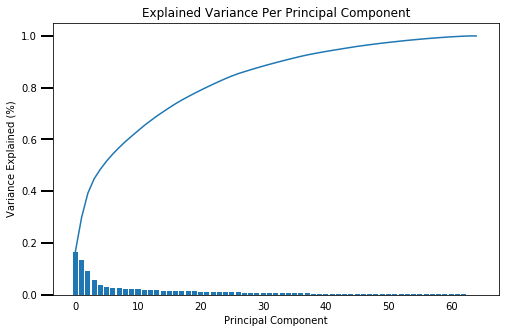

In [78]:
scree_plot(pca)

In [79]:
azdias2_scaled.shape[1]

65

In [80]:
# Investigate the variance accounted for by each principal component.

for v in np.arange(5, 66, 5):
    print((v, pca.explained_variance_ratio_[:v].sum()))

(5, 0.48537428667413446)
(10, 0.61316583734140706)
(15, 0.70681137761357482)
(20, 0.77824653268853938)
(25, 0.83550935305960572)
(30, 0.87668501078385752)
(35, 0.909392437630404)
(40, 0.93574132828017009)
(45, 0.95581970661045679)
(50, 0.97222581872680125)
(55, 0.98507501682465504)
(60, 0.9949773880877949)
(65, 1.0)


In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 25)
azdias2_pca = pca.fit_transform(azdias2_scaled)

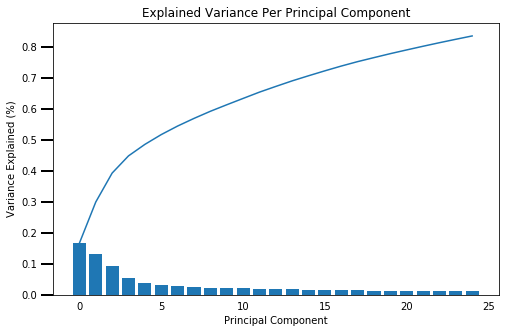

In [82]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

The scaled dataset has 65 components. I reduced this to 25 PCA components to capture 83.6% of the variance in the data. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight(df,i):

    weight = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[i]
    weight.sort_values(ascending = False, inplace = True)
    
    return weight

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight(azdias2_scaled, 1)

ALTERSKATEGORIE_GROB           0.263254
FINANZ_VORSORGER               0.236651
SEMIO_ERL                      0.231589
SEMIO_LUST                     0.185577
RETOURTYP_BK_S                 0.163992
W_KEIT_KIND_HH                 0.117944
SEMIO_KRIT                     0.113868
FINANZ_HAUSBAUER               0.110565
SEMIO_KAEM                     0.110012
ANREDE_KZ                      0.088469
EWDICHTE                       0.086553
ORTSGR_KLS9                    0.085412
PLZ8_ANTG3                     0.084374
PLZ8_ANTG4                     0.080080
FINANZ_MINIMALIST              0.074819
SEMIO_DOM                      0.070280
CAMEO_INTL_2015_WEALTH         0.065623
ARBEIT                         0.063073
WOHNDAUER_2008                 0.062941
KBA05_ANTG4                    0.061750
RELAT_AB                       0.060842
PLZ8_ANTG2                     0.058700
ANZ_HAUSHALTE_AKTIV            0.057273
HH_EINKOMMEN_SCORE             0.047091
KBA05_ANTG3                    0.037002


In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight(azdias2_scaled, 2)

SEMIO_VERT                        0.345590
SEMIO_SOZ                         0.262700
SEMIO_FAM                         0.250374
SEMIO_KULT                        0.235975
FINANZ_MINIMALIST                 0.156888
RETOURTYP_BK_S                    0.107602
FINANZ_VORSORGER                  0.100416
W_KEIT_KIND_HH                    0.089639
ALTERSKATEGORIE_GROB              0.077815
SEMIO_REL                         0.070254
SEMIO_LUST                        0.063796
SEMIO_MAT                         0.056013
GREEN_AVANTGARDE                  0.050115
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.048147
ORTSGR_KLS9                       0.047176
EWDICHTE                          0.046342
PLZ8_ANTG4                        0.043919
PLZ8_ANTG3                        0.043805
ARBEIT                            0.034597
WOHNDAUER_2008                    0.033058
RELAT_AB                          0.031661
PLZ8_ANTG2                        0.029613
CAMEO_INTL_2015_WEALTH            0.025347
KBA05_ANTG4

In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight(azdias2_scaled, 3)

GREEN_AVANTGARDE                  0.385131
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.384320
EWDICHTE                          0.253407
ORTSGR_KLS9                       0.248118
ONLINE_AFFINITAET                 0.133470
PLZ8_HHZ                          0.130294
SEMIO_DOM                         0.115482
OST_WEST_KZ                       0.111699
KBA05_ANTG1                       0.103179
PLZ8_ANTG2                        0.098959
RELAT_AB                          0.097540
ANZ_PERSONEN                      0.094728
PLZ8_ANTG3                        0.086259
FINANZ_UNAUFFAELLIGER             0.084717
SEMIO_KAEM                        0.075673
MOBI_REGIO                        0.072083
CAMEO_INTL_2015_LIFE_STAGE        0.065688
FINANZ_MINIMALIST                 0.065408
PLZ8_ANTG4                        0.063288
KBA05_GBZ                         0.061509
ARBEIT                            0.060021
SEMIO_TRADV                       0.059107
SEMIO_RAT                         0.050548
KBA13_ANZAH

### Discussion 2.3: Interpret Principal Components


1. **First Principal Component**
    - The component is positively associated with:
         - ALTERSKATEGORIE_GROB (Estimated age)
         - FINANZ_VORSORGER (Financial typology: be prepared)
         - SEMIO_ERL (Personality typology: event-oriented)
         - SEMIO_LUST (Personality typology: sensual-minded)
         - RETOURTYP_BK_S (Return type)

    - The component is negitively associated with:
        - SEMIO_REL (Personality typology: religious)
        - PRAEGENDE_JUGENDJAHRE_YEARS (Decade of person's youth)
        - FINANZ_SPARER (Financial typology: money-saver)
        - SEMIO_TRADV (Personality typology: tradional-minded)
        - SEMIO_PFLICHT (Personality typology: dutiful)
        
    - *There is a correleation between ALTERSKATEGORIE_GROB and PRAEGENDE_JUGENDJAHRE_YEARS, which is expected as both these are related to how old a person is.*
    
    
2. **Second Principal Component**
    - The component is positively associated with:
        - SEMIO_VERT (Personality typology: dreamful)
        - SEMIO_SOZ (Personality typology: socially-minded)
        - SEMIO_FAM (Personality typology: family-minded)
        - SEMIO_KULT (Personality typology: cultural-minded)
        - FINANZ_MINIMALIST (Financial typology: low financial interest)
                 
    - The component is negitively associated with:
        - ANREDE_KZ (Gender)
        - SEMIO_KAEM (Personality typology: combative attitude)
        - SEMIO_DOM (Personality typology: dominant-minded)
        - SEMIO_KRIT (Personality typology: critical-minded)
        - SEMIO_RAT (Personality typology: rational)   
        
    - *There appears to be both a positive and negative correlation between gender and personality (SEMIO). It is likely that a specific gender has a positive correlation with being combative, dominant, critical, and rational and a negative correlation with being dreamful, socially-minded, family-minded, and cultural-minded.* 
    
    
3. **Third Principal Component**
    - The component is positively associated with:
        - GREEN_AVANTGARDE (Membership in environmental sustainability as part of youth)
        - PRAEGENDE_JUGENDJAHRE_MOVEMENT (Dominant movement during youth)    
        - EWDICHTE (Density of households per square kilometer)                          
        - ORTSGR_KLS9 (Size of community)                       
        - PLZ8_HHZ (Number of households within the PLZ8 region)                          
     
    - The component is negitively associated with:
        - WOHNLAGE (Neighborhood quality)                      
        - KKK (Purchasing power in region)                                      
        - HH_EINKOMMEN_SCORE (Estimated household net income)               
        - BALLRAUM (Distance to nearest urban center)                              
        - INNENSTADT (Distance to city center)
        
    - *There is a positive relationship between GREEN_AVANTGARDE and ORTSGR_KLS9. However, these have a negative association with neighborhood quality (WOHNLAGE).*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

# Over a number of different cluster counts...
average = []

for k in range(2,26,1):
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = k).fit(azdias2_pca)
    
    # Obtain a score related to the model fit
    score = np.abs(kmeans.score(azdias2_pca))
    
    # compute the average within-cluster distances.
    print('k ={}, Average distance = {}'.format(k, score / azdias2_pca.shape[0]))
    
    average.append(score / azdias2_pca.shape[0])

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
k = range(2,26)

plt.figure (figsize = (20, 10));
plt.plot(k, average, linestyle='-', marker='o');
plt.xlabel('Number of Clusters (k)');
plt.ylabel('Average Distance');
plt.title('K-Means');
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26]);



In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 18
kmeans = KMeans(n_clusters = k)
model = kmeans.fit(azdias2_pca)
population_predictions = model.predict(azdias2_pca)

### Discussion 3.1: Apply Clustering to General Population

The elbow in the graph appears to be located at k = 18 so the population will be split into 18 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [88]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [89]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [90]:
customers.isnull().sum().sum()

2252274

In [91]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_lau

In [92]:
list(set(azdias2.columns)-set(customers_cleaned.columns))

['VERS_TYP']

In [93]:
customers_cleaned['VERS_TYP'] = customers['VERS_TYP']

In [94]:
customers_cleaned.shape      

(141725, 65)

In [95]:
azdias2.shape

(798061, 65)

In [96]:
customers_cleaned.isnull().sum().sum()

84425

In [97]:
# Use imputer to replace missing values with the mean

customers_cleaned = pd.DataFrame(imputer.transform(customers_cleaned), columns = customers_cleaned.columns)

In [98]:
customers_cleaned.isnull().sum().sum()

0

In [99]:
# Scale the data

customers_scaled = scaler.transform(customers_cleaned)

In [100]:
# Apply PCA to the data.

customers_pca = pca.transform(customers_scaled)

In [101]:
#Kmeans

customers_predictions = model.predict(customers_pca)
customers_predictions

array([16, 16, 16, ..., 16, 16, 16], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def proportion(df):
    df = pd.Series(df)
    cluster = df.value_counts()
    proportion = cluster / len(df)
    
    return proportion

In [103]:
# Create dataframes for the the proportion of the population (pp) and proportion of customers (cp)
# Merge the 2 dataframes

pp = pd.DataFrame(proportion(population_predictions).sort_index())
pp.columns = ['Population']

cp = pd.DataFrame(proportion(customers_predictions).sort_index())
cp.columns = ['Customers']

proportions = [pp, cp]

proportions = pd.merge(left = pp, left_index=True, right = cp, right_index=True, how='inner')
proportions

,Population,Customers
9,0.004070,0.000508
14,0.099264,0.000706
16,0.055472,0.998786


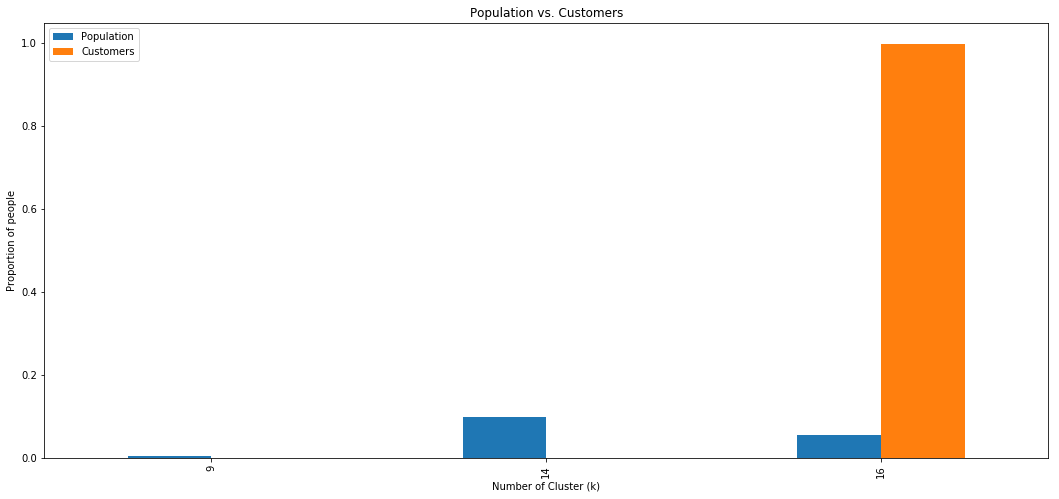

In [104]:
proportions.plot(y=['Population', 'Customers'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customers')
plt.xlabel('Number of Cluster (k)')
plt.ylabel('Proportion of people')
plt.show()

In [105]:
def representation(k):
    x = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_predictions == k)])).round()
    x = pd.DataFrame(data = x, columns = customers_cleaned.columns)
    
    return x

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

representation(15).mean() #overrepresented

ALTERSKATEGORIE_GROB             NaN
ANREDE_KZ                        NaN
FINANZ_MINIMALIST                NaN
FINANZ_SPARER                    NaN
FINANZ_VORSORGER                 NaN
FINANZ_ANLEGER                   NaN
FINANZ_UNAUFFAELLIGER            NaN
FINANZ_HAUSBAUER                 NaN
GREEN_AVANTGARDE                 NaN
HEALTH_TYP                       NaN
RETOURTYP_BK_S                   NaN
SEMIO_SOZ                        NaN
SEMIO_FAM                        NaN
SEMIO_REL                        NaN
SEMIO_MAT                        NaN
SEMIO_VERT                       NaN
SEMIO_LUST                       NaN
SEMIO_ERL                        NaN
SEMIO_KULT                       NaN
SEMIO_RAT                        NaN
SEMIO_KRIT                       NaN
SEMIO_DOM                        NaN
SEMIO_KAEM                       NaN
SEMIO_PFLICHT                    NaN
SEMIO_TRADV                      NaN
SOHO_KZ                          NaN
ANZ_PERSONEN                     NaN
A

In [107]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

representation(16).mean() #overrepresented

ALTERSKATEGORIE_GROB                10.826100
ANREDE_KZ                            2.306620
FINANZ_MINIMALIST                  -44.413661
FINANZ_SPARER                       22.251701
FINANZ_VORSORGER                    41.546121
FINANZ_ANLEGER                      95.638997
FINANZ_UNAUFFAELLIGER             -107.627963
FINANZ_HAUSBAUER                   132.207131
GREEN_AVANTGARDE                    14.212217
HEALTH_TYP                          61.175630
RETOURTYP_BK_S                      26.087974
SEMIO_SOZ                           89.685877
SEMIO_FAM                          -14.554541
SEMIO_REL                           56.387113
SEMIO_MAT                          -56.806532
SEMIO_VERT                         -68.446999
SEMIO_LUST                          99.847068
SEMIO_ERL                           67.309778
SEMIO_KULT                         119.508205
SEMIO_RAT                          -12.151887
SEMIO_KRIT                        -110.150728
SEMIO_DOM                         

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

representation(12).mean() d#underrepresented

SyntaxError: invalid syntax (<ipython-input-108-a187fbc8fe1d>, line 4)

### Discussion 3.3: Compare Customer Data to Demographics Data

Clusters 15 and 16 are overrepresented in the customer data.

The population that is popular with the mail-order company are prosperous households with very high income. Families with school age children, people with low movement patterns, and those with a middle to high online affinity.


Cluster 12 is underrepresented in the customer data.

The population that is unpopular with the mail-order company are poorer households with lower income. Elders in retirement, those with very high movement patterns, and people with a low online affinity.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
!!jupyter nbconvert *.ipynb